In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize
import scipy.stats

In [2]:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
uvw_match_tolerance = 1e-12

In [3]:
# Load data from pyuvsim simulation:
data_sim_compact = UVData()
data_sim_compact.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Remove autos
data_sim_compact.select(ant_str='cross')
# Use only XX polarizations
data_sim_compact.select(polarizations=[-5])

# Convert baselines to have u>0
data_sim_compact.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

baseline_groups, vec_bin_centers, lengths, conjugates = data_sim_compact.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

# Define constants
N_red_baselines = np.shape(baseline_groups)[0]
N_ants = data_sim_compact.Nants_data

# Reorder visibilities
data_sim_vis_no_noise = np.zeros(N_red_baselines, dtype=np.complex_)
for red_group in range(N_red_baselines):
    found_group = False
    for red_group_2 in range(N_red_baselines):
        if np.abs(np.sum(data_sim_compact.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            data_sim_vis_no_noise[red_group] = data_sim_compact.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

Telescope square_grid is not in known_telescopes.


In [4]:
# Make noiseless data
data_sim_expanded = data_sim_compact.copy()
data_sim_expanded.inflate_by_redundancy()

# Define constant
N_vis = data_sim_expanded.Nbls

Missing some redundant groups. Filling in available data.


In [5]:
# Load data with missing sources from pyuvsim simulation:
model_sim = UVData()
model_sim.read_uvh5('{}/square_grid_100mjy_sim_results.uvh5'.format(path))
#Added for testing
#model_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Remove autos
model_sim.select(ant_str='cross')
# Use only XX polarizations
model_sim.select(polarizations=[-5])

# Convert baselines to have u>0
model_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

model_sim_visibilities = np.zeros(N_red_baselines, dtype=np.complex_)
for red_group in range(N_red_baselines):
    found_group = False
    for red_group_2 in range(N_red_baselines):
        if np.abs(np.sum(model_sim.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            model_sim_visibilities[red_group] = model_sim.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

Telescope square_grid is not in known_telescopes.


In [6]:
# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(N_red_baselines, 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(N_red_baselines):
    for bl_2 in [ind for ind in range(N_red_baselines) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176
# Invert the matrix
baseline_cov_inv = np.linalg.inv(baseline_cov_array)

# Create the A matrix
a_mat = np.zeros((N_vis, N_red_baselines))
for vis_ind in range(N_vis):
    for red_group in range(N_red_baselines):
        if np.abs(np.sum(data_sim_expanded.uvw_array[vis_ind]-vec_bin_centers[red_group])) < uvw_match_tolerance:
            a_mat[vis_ind, red_group] = 1
            break
        
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((N_vis, N_ants), dtype=np.int)
gains_exp_mat_2 = np.zeros((N_vis, N_ants), dtype=np.int)
for baseline in range(N_vis):
    gains_exp_mat_1[baseline, data_sim_expanded.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim_expanded.ant_2_array[baseline]] = 1

In [7]:
print(data_sim_expanded.ant_1_array[0])

0


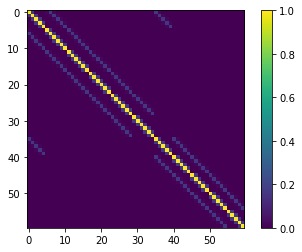

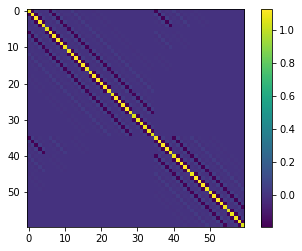

In [8]:
plt.imshow(baseline_cov_array)
plt.colorbar()
plt.show()

plt.imshow(baseline_cov_inv)
plt.colorbar()
plt.show()

In [62]:
def cost_function(
    x, 
    N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:N_ants]+1j*x[N_ants:2*N_ants]
    
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost


def calc_negloglikelihood(
    gains, fitted_visibilities, data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev, model_stddev
):
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_inv), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob/data_stddev**2 + prior/model_stddev**2

In [10]:
print(np.abs(np.dot(np.matmul(np.conj(model_sim_visibilities), baseline_cov_inv), model_sim_visibilities)))
print(np.real(np.dot(np.matmul(model_sim_visibilities, baseline_cov_inv), model_sim_visibilities)))

2424.224641175818
216.3504068670743


In [158]:
def jac_function(x, 
    N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):
    
    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:N_ants]+1j*x[N_ants:2*N_ants]
    
    gains_grad = calc_gains_grad(
        gains, fitted_visibilities, data_visibilities,
        a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev
    )
    vis_grad = calc_vis_grad(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    
    grads = np.zeros(N_ants*2+N_red_baselines*2)
    grads[:N_ants] = np.real(gains_grad)
    grads[N_ants:2*N_ants] = np.imag(gains_grad)
    grads[-2*N_red_baselines:-N_red_baselines] = np.real(vis_grad)
    grads[-N_red_baselines:] = np.imag(vis_grad)
    return grads


def calc_gains_grad(
    gains, fitted_visibilities, data_visibilities,
    a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev
):

    gains1_expanded = np.matmul(gains_exp_mat_1, gains)
    gains2_expanded = np.matmul(gains_exp_mat_2, gains)
    vis_expanded = np.matmul(a_mat, fitted_visibilities)

    gains_grad_term_1 = (
        np.abs(gains1_expanded*vis_expanded)**2.*gains2_expanded
        - np.conj(data_visibilities)*gains1_expanded*vis_expanded
    )
    gains_grad_term_2 = (
        np.abs(np.conj(gains2_expanded)*vis_expanded)**2.*gains1_expanded
        - data_visibilities*gains2_expanded*np.conj(vis_expanded)
    )
    gains_grad = (2./data_stddev**2.)*(
        np.matmul(gains_exp_mat_2.T, gains_grad_term_1)
        + np.matmul(gains_exp_mat_1.T, gains_grad_term_2)
    )

    return gains_grad


def calc_vis_grad(
    gains, fitted_visibilities, data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev, model_stddev
):

    vis_diff = fitted_visibilities-model_visibilities
    gains1_expanded = np.matmul(gains_exp_mat_1, gains)
    gains2_expanded = np.matmul(gains_exp_mat_2, gains)
    gains_expanded = gains1_expanded*np.conj(gains2_expanded)
    
    vis_grad_term_1 = (2./data_stddev**2.) * (
        np.matmul(np.abs(gains_expanded)**2, a_mat**2.)*fitted_visibilities
    )
    vis_grad_term_2 = (-2./data_stddev**2.) * (
        np.matmul(data_visibilities*np.conj(gains_expanded), a_mat)
    )
    vis_grad_term_3 = (2./model_stddev**2.) * np.matmul(baseline_cov_inv, vis_diff)
    vis_grad = vis_grad_term_1 + vis_grad_term_2 + vis_grad_term_3

    return vis_grad

In [160]:
# Check that the gradients are correct

step_size = 1.
use_ind = 0
gains_test_1 = 1.+np.random.normal(0, .01, N_ants)+1j*np.random.normal(0, .01, N_ants)
#gains_test_1 = np.full(N_ants, 0.+0.j)
gains_test_1[use_ind+1] = 1.
gains_test_2 = np.copy(gains_test_1)
gains_test_2[use_ind] += step_size
vis_test = model_sim_visibilities+np.random.normal(0, .01, N_red_baselines)+1j*np.random.normal(0, .01, N_red_baselines)
vis_test_1 = np.copy(model_sim_visibilities)
vis_test_2 = np.copy(model_sim_visibilities)
#vis_test_2[use_ind] += step_size
#data_test = np.matmul(a_mat, model_sim_visibilities)
data_test = np.zeros(N_vis)

data_stddev_use = .2
model_stddev_use = model_stddev_sim

baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))
        
# Check the cost function to ensure it's actually minimizing
cost1 = calc_negloglikelihood(
    gains_test_1, vis_test_1, data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)
cost2 = calc_negloglikelihood(
    gains_test_2, vis_test_2, data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)
grad_calculated = (cost2-cost1)/step_size

gains_grad = calc_gains_grad(
    (gains_test_1+gains_test_2)/2., (vis_test_1+vis_test_2)/2., data_test,
    a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use
)
vis_grad = calc_vis_grad(
    (gains_test_1+gains_test_2)/2., (vis_test_1+vis_test_2)/2., data_test, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    data_stddev_use, model_stddev_use
)

print(grad_calculated)
print(gains_grad[use_ind])
print(vis_grad[use_ind])

120638.86534477165
(120638.86534477168-646.9440771034793j)
(-2193.9115105800934-13522.891689730752j)


In [16]:
def produce_kde(data, xvals, yvals):
    
    data_real = np.real(data).flatten()
    data_imag = np.imag(data).flatten()
    rvs = np.append(data_real[:,np.newaxis],
                    data_imag[:,np.newaxis],
                    axis=1)

    kde = scipy.stats.kde.gaussian_kde(rvs.T)

    # Regular grid to evaluate KDE upon
    x,y = np.meshgrid(xvals, yvals)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)

    kde_vals = kde(grid_coords.T)
    kde_vals = kde_vals.reshape(len(xvals),len(yvals))
    
    percent_vals = np.zeros_like(kde_vals)
    kde_total = np.sum(kde_vals)
    running_total = 0.
    for val in np.sort(kde_vals.flatten())[::-1]: # Sort values in reverse order
        percent_vals[np.where(kde_vals == val)] = running_total/kde_total
        running_total += val
    
    return kde_vals, percent_vals

0.4092157966687509


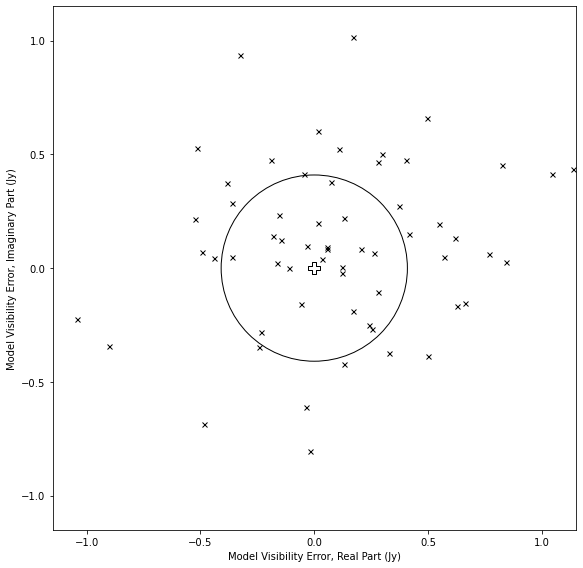

In [45]:
# Calculate deviation between model and true data
model_stddev_sim = np.sqrt(np.mean(np.abs(model_sim_visibilities-data_sim_vis_no_noise)**2)/2.)
print(model_stddev_sim)

plt.figure(figsize=[10,8])
plt.plot(
    np.real(model_sim_visibilities-data_sim_vis_no_noise).flatten(), 
    np.imag(model_sim_visibilities-data_sim_vis_no_noise).flatten(),
    'x', color='black', markersize=5
)
plt.axis('square')
plt.xlim(-1.15,1.15)
plt.ylim(-1.15,1.15)
#cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
circle = plt.Circle((0, 0), model_stddev_sim, fill=False, color='black')
plt.gcf().gca().add_artist(circle)
circle = plt.Circle((0, 0), data_stddev, fill=False, color='blue', linestyle='dashed')
plt.gcf().gca().add_artist(circle)
#plt.clabel(cont, inline=2, fontsize=10)
plt.xlabel('Model Visibility Error, Real Part (Jy)')
plt.ylabel('Model Visibility Error, Imaginary Part (Jy)')
#plt.title(data_titles[data_set_ind])
plt.tight_layout() # Ensure that axes labels don't get cut off
#plt.savefig('{}/{}'.format(save_path, 'model_vis_scatter.png'),dpi=600)
plt.show()

In [34]:
def optimize_with_scipy_simple(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    method = 'Powell'
    maxiter = 100000
    xtol = 1e-20
    ftol = 1e-20
    
    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'xtol': xtol, 'ftol': ftol, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [19]:
def optimize_with_scipy_jac(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    method = 'BFGS'
    maxiter = 1e5

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, jac=jac_function,
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'disp': True, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [218]:
def gains_cost_function(
    gains_expanded, 
    fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    gains = gains_expanded[:N_ants]+1j*gains_expanded[N_ants:]
    
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost


def gains_jac_function(
    gains_expanded, 
    fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    gains = gains_expanded[:N_ants]+1j*gains_expanded[N_ants:]
    gains_grad = calc_gains_grad(
        gains, fitted_visibilities, data_visibilities,
        a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev
    )
    gains_grad_expanded = np.concatenate((np.real(gains_grad), np.imag(gains_grad)))
    return gains_grad_expanded


def vis_cost_function(
    vis_expanded, 
    gains, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = vis_expanded[:N_red_baselines]+1j*vis_expanded[N_red_baselines:]
    cost = calc_negloglikelihood(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    return cost 


def vis_jac_function(
    vis_expanded, 
    gains, N_red_baselines, N_ants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = vis_expanded[:N_red_baselines]+1j*vis_expanded[N_red_baselines:]
    vis_grad = calc_vis_grad(
        gains, fitted_visibilities, data_visibilities, model_visibilities, 
        baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
        data_stddev, model_stddev
    )
    vis_grad_expanded = np.concatenate((np.real(vis_grad), np.imag(vis_grad)))
    return vis_grad_expanded 

In [235]:
def optimize_in_two_parts(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    method = 'BFGS'
    n_iter = 1000

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    
    fitted_visibilities = np.copy(fitted_visibilities_init)
    gains = np.copy(gains_init)
    
    for iter_ind in range(n_iter):
    
        # Calculate gains
        # Expand the initialized values
        gains_expanded = np.concatenate((
            np.real(gains), np.imag(gains)
        ))
        # Minimize the gains cost function
        result = scipy.optimize.minimize(
            gains_cost_function, gains_expanded, jac=gains_jac_function,
            args=(
                fitted_visibilities, N_red_baselines, N_ants, baseline_cov_inv, 
                model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
                data_stddev, model_stddev
            ),
            method=method, options={'disp': False}
        )
        # Update gains
        gains = result.x[:N_ants]+1j*result.x[N_ants:]
        # Ensure that the angle of the gains is mean-zero
        avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains))), np.mean(np.cos(np.angle(gains))))
        gains *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

        # Calculate visibilities
        # Expand the initialized values
        vis_expanded = np.concatenate((
            np.real(fitted_visibilities), np.imag(fitted_visibilities)
        ))
        result = scipy.optimize.minimize(
            vis_cost_function, vis_expanded, jac=vis_jac_function,
            args=(
                gains, N_red_baselines, N_ants, baseline_cov_inv, 
                model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
                data_stddev, model_stddev
            ),
            method=method, options={'disp': False}
        )
        # Update visibilities
        fitted_visibilities = result.x[:N_red_baselines]+1j*result.x[N_red_baselines:]    

    return gains, fitted_visibilities

In [22]:
def optimize_with_scipy_constrained(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):

    #method = 'BFGS'
    method = 'trust-constr'
    maxiter = 1e5 # Defaults to 1000

    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    # Expand the initialized values
    x0 = np.concatenate((
        np.real(gains_init), np.imag(gains_init),
        np.real(fitted_visibilities_init), np.imag(fitted_visibilities_init)
    ))
    
    # Produce constraint
    constraint_vec = np.zeros(2*N_ants + 2*N_red_baselines)
    constraint_vec[N_ants:2*N_ants] = 1
    constraint = scipy.optimize.LinearConstraint(constraint_vec.T, 0, 0)

    # Minimize the cost function
    result = scipy.optimize.minimize(
        cost_function, x0, jac=jac_function,
        constraints=[constraint],
        args=(
            N_red_baselines, N_ants, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities,
            data_stddev, model_stddev
        ),
        method=method, options={'disp': True, 'maxiter': maxiter}
    )
    print(result.message)

    gains_fit = result.x[:N_ants]+1j*result.x[N_ants:2*N_ants]
    vis_fit = result.x[-2*N_red_baselines:-N_red_baselines]+1j*result.x[-N_red_baselines:]
    # Ensure that the angle of the gains is mean-zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)

    return gains_fit, vis_fit

In [23]:
def optimize_with_gradient_descent(
    data_visibilities, model_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev, model_stddev,
    gains_init=None, fitted_visibilities_init=None
):
    
    n_iter = 100
    learning_rate = .1
    term_condition = .035
    
    if gains_init is None: # Initialize the gains to 1
        gains_init = np.full(N_ants, 1.+0.j)
    if fitted_visibilities_init is None: # Initialize the fitted visibilities to the model visibilities
        fitted_visibilities_init = model_visibilities
    
    # Initialize values
    gains_fit = np.copy(gains_init)
    vis_fit = np.copy(fitted_visibilities_init)
    
    iter_ind = 0
    term_condition_fulfilled = 0
    #while term_condition_fulfilled < 3:
    for iter_ind in range(n_iter):
        
        # Check the cost function to ensure it's actually minimizing
        negloglikelihood = calc_negloglikelihood(
            gains_fit, vis_fit, data_visibilities, model_visibilities, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev, model_stddev
        )
        print(negloglikelihood)
        
        gains_grad = calc_gains_grad(
            gains_fit, vis_fit, data_visibilities,
            a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev
        )
        vis_grad = calc_vis_grad(
            gains_fit, vis_fit, data_visibilities, model_visibilities, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            data_stddev, model_stddev
        )
        
        if iter_ind > 0: # Use the Barzilai–Borwein method of determining step size
            numerator = np.abs(
                np.sum((gains_fit-gains_fit_old)*(gains_grad-gains_grad_old)) 
                + np.sum((vis_fit-vis_fit_old)*(vis_grad-vis_grad_old))
            )
            denominator = np.sum(np.abs(gains_grad-gains_grad_old)**2.) + np.sum(np.abs(vis_grad-vis_grad_old)**2.)
            step_size = numerator/denominator
        else: # Arbitrary, but not too big
            step_size = np.min([data_stddev, model_stddev])/(
                1000.*np.sqrt(np.sum(np.abs(gains_grad)**2.) + np.sum(np.abs(vis_grad**2.)))
            )
        
        gains_fit_old = np.copy(gains_fit)
        vis_fit_old = np.copy(vis_fit)
        gains_grad_old = np.copy(gains_grad)
        vis_grad_old = np.copy(vis_grad)
        
        gains_fit -= learning_rate*step_size*gains_grad
        vis_fit -= learning_rate*step_size*vis_grad

        # Ensure that the angle of the gains is mean-zero
        avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
        gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
        
        # Check termination condition
        #print(learning_rate*step_size*np.sqrt(np.sum(np.abs(gains_grad)**2)+np.sum(np.abs(vis_grad)**2)))
        if learning_rate*step_size*np.sqrt(np.sum(np.abs(gains_grad)**2)+np.sum(np.abs(vis_grad)**2)) < term_condition:
            term_condition_fulfilled += 1
        else:
            term_condition_fulfilled = 0
            
        iter_ind += 1

    return gains_fit, vis_fit

In [187]:
data_stddev_use = .2
model_stddev_use = model_stddev_sim

data_visibilities = data_vis_noisy[:, 0]

#Added for testing
baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))

gains_fit, vis_fit = optimize_with_gradient_descent(
    data_visibilities, model_sim_visibilities, 
    baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
    N_red_baselines, N_ants, data_stddev_use, model_stddev_use,
    gains_init=None, fitted_visibilities_init=None
)
print(gains_fit)

4562.0444079760655
4561.872957222712
4525.009211933614
4492.639379777402
4464.509001759618
4439.970229026758
4418.47708393123
4399.573436363019
4382.877739771211
4368.07033921592
4354.882976396786
4343.090110487509
4332.501738437584
4322.957453298507
4314.321524680526
4306.478823163612
4299.331441674053
4292.795892595486
4286.800780635976
4281.28486899587
4276.195470822682
4271.487109838018
4267.120403824843
4263.061132741117
4259.279459883256
4255.74928001161
4252.447672876705
4249.354444319652
4246.451740202159
4243.723720965994
4241.1562867225575
4238.736844508396
4236.454110775474
4234.297943369041
4232.259198223963
4230.329606818664
4228.50167109389
4226.76857309572
4225.124097059098
4223.562562026109
4222.0787634061835
4220.667922144826
4219.325640382472
4218.047862663753
4216.830841905918
4215.671109458727
4214.565448691216
4213.51087162672
4212.504598219492
4211.544037926762
4210.626773280434
4209.750545205508
4208.913239867998
4208.112876865784
4207.347598601233
4206.615660696

In [238]:
# Generate noisy data
n_trials=3
#n_trials=1
data_stddev = .3
#data_stddev = 0

data_vis_noisy = np.zeros((N_vis, n_trials), dtype=np.complex_)
for trial_ind in range(n_trials):
    data_vis_noisy[:, trial_ind] = (
        data_sim_expanded.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, N_vis) 
        + 1j*np.random.normal(0, data_stddev, N_vis)
    )

In [ ]:
#model_stddev_sim = .4
model_stddev_use_vals = [model_stddev_sim/1000000, model_stddev_sim, model_stddev_sim*1000000]
#model_stddev_use_vals = [model_stddev_sim/1000, model_stddev_sim, model_stddev_sim*1000]
data_stddev_use = data_stddev
#data_stddev_use = .2

gain_vals = np.zeros((N_ants, n_trials, len(model_stddev_use_vals)), dtype=np.complex_)
vis_diff_vals = np.zeros((N_red_baselines, n_trials, len(model_stddev_use_vals)), dtype=np.complex_)

for stddev_ind, model_stddev_use in enumerate(model_stddev_use_vals):

    for trial in range(n_trials):
        print('***Version {}, Trial {}***'.format(stddev_ind+1, trial+1))
        data_visibilities = data_vis_noisy[:, trial]
        
        #Added for testing
        baseline_cov_inv = np.diag(np.full(np.shape(baseline_cov_inv)[0], 1.))
        data_sim_vis_no_noise_use = np.copy(data_sim_vis_no_noise)
        #data_sim_vis_no_noise_use[0] += 1
        
        gains_fit, vis_fit = optimize_in_two_parts(
            data_visibilities, model_sim_visibilities,
            #data_sim_vis_no_noise_use, 
            baseline_cov_inv, a_mat, gains_exp_mat_1, gains_exp_mat_2,
            N_red_baselines, N_ants, data_stddev_use, model_stddev_use,
            gains_init=None, fitted_visibilities_init=None
        )

        gain_vals[:, trial, stddev_ind] = gains_fit-1
        vis_fit_diff = vis_fit-data_sim_vis_no_noise
        vis_diff_vals[:, trial, stddev_ind] = vis_fit_diff

***Version 1, Trial 1***
***Version 1, Trial 2***
***Version 1, Trial 3***
***Version 2, Trial 1***


In [ ]:
plot_range = .05
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .008]

for data_set_ind in range(len(model_stddev_use_vals)):
    
    plot_data = gain_vals[:, :, data_set_ind]

    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(), np.imag(plot_data).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(plot_data, bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Frac. Gain Error, Real Part')
    plt.ylabel('Frac. Gain Error, Imag. Part')
    plt.title('Used Model Variance {}'.format(model_stddev_use_vals[data_set_ind]))
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.show()

In [ ]:
plot_range = .9
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .022]

for data_set_ind in range(len(model_stddev_use_vals)):
    
    plot_data = vis_diff_vals[:, :, data_set_ind]

    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(), np.imag(plot_data).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    #kde, percent_plot = produce_kde(plot_data, bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    #cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Fit Vis. Error, Real Part (Jy)')
    plt.ylabel('Fit Vis. Error, Imag. Part (Jy)')
    plt.title('Used Model Variance {}'.format(model_stddev_use_vals[data_set_ind]))
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.show()

0.9915115109924169
[28129179.94295381 16319396.33096085  7812804.35127654  2464045.40771734
   133775.89009088   688404.31482284  3999840.88825914  9945258.85555549
 18406867.03343949 29271692.95837395 42431376.11293075 57781970.72259144
 75223757.64287539]


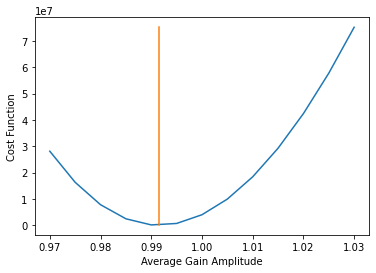

0.9980838569502954
[1576.5954404  1560.56456574 1547.96018742 1538.63297076 1532.43974054
 1529.24321231 1528.91173632 1531.31905346 1536.34406271 1543.87059936
 1553.78722355 1565.98701863 1580.36739872]


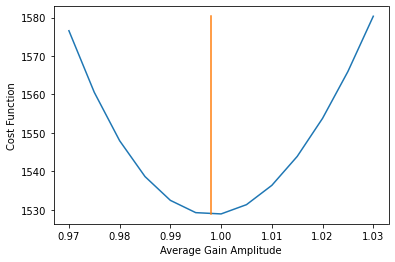

0.9918646749191882
[1435.1799857  1435.17996883 1435.1799554  1435.17994528 1435.17993831
 1435.17993435 1435.17993328 1435.17993497 1435.1799393  1435.17994614
 1435.17995539 1435.17996694 1435.17998069]


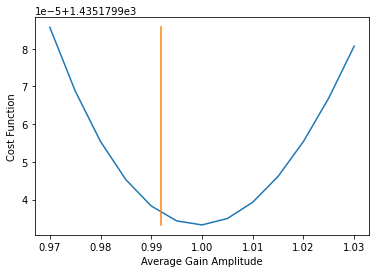

In [236]:
plt.figure()
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, stddev_ind]+1
    visibilities = vis_diff_vals[:, use_trial, stddev_ind] + data_sim_vis_no_noise
    mean_gain_amp = np.mean(np.abs(gains))
    print(mean_gain_amp)
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp/mean_gain_amp
        scaled_visibilities = visibilities*(mean_gain_amp/use_gain_amp)**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    plt.plot([mean_gain_amp,mean_gain_amp], [np.min(cost_function_result),np.max(cost_function_result)])
    plt.xlabel('Average Gain Amplitude')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

[1.21871252e+14 8.33314620e+13 5.25169283e+13 2.90918852e+13
 1.27344040e+13 3.13578830e+12 3.83884152e+03 3.04311076e+12
 1.19927799e+13 2.65877567e+13 4.65774050e+13 7.17212511e+13
 1.01788551e+14]


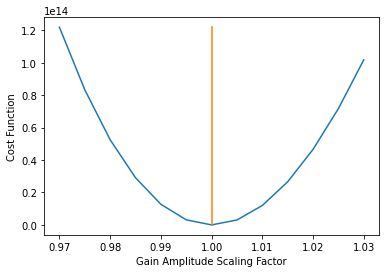

[362.55074518 324.31054853 293.74011389 270.50607928 254.28882008
 244.78184985 241.69124956 244.73512355 253.64308099 268.15574152
 288.02426381 313.00989595 342.8835465 ]


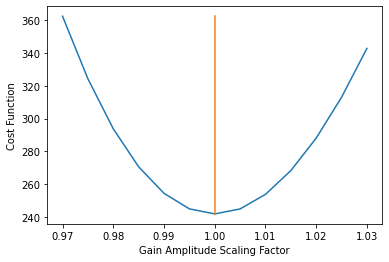

[4.49112751e-10 4.02323358e-10 3.63484190e-10 3.32252437e-10
 3.08299378e-10 2.91309768e-10 2.80981249e-10 2.77023798e-10
 2.79159194e-10 2.87120511e-10 3.00651633e-10 3.19506799e-10
 3.43450158e-10]


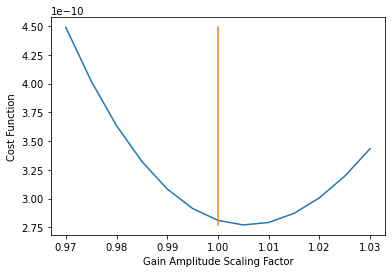

In [29]:
plt.figure()
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, stddev_ind]+1
    visibilities = vis_diff_vals[:, use_trial, stddev_ind] + data_sim_vis_no_noise
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp
        scaled_visibilities = visibilities/use_gain_amp**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    plt.plot([1,1], [np.min(cost_function_result),np.max(cost_function_result)])
    plt.xlabel('Gain Amplitude Scaling Factor')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

[3.01596083e+14 2.70704626e+14 2.47230014e+14 2.30847543e+14
 2.21245923e+14 2.18126690e+14 2.21203650e+14 2.30202347e+14
 2.44859556e+14 2.64922798e+14 2.90149885e+14 3.20308471e+14
 3.55175642e+14]


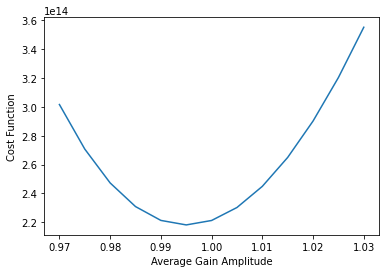

[325.16065379 294.2691962  270.7945842  254.41211364 244.81049356
 241.69126052 244.76822058 253.76691758 268.42412624 288.48736896
 313.71445505 343.87304129 378.7402127 ]


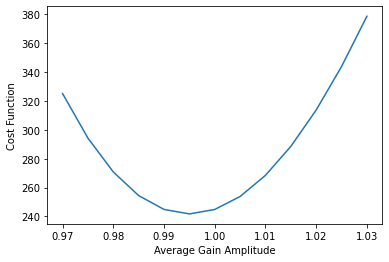

[23.56457052 23.56457052 23.56457052 23.56457052 23.56457052 23.56457052
 23.56457052 23.56457052 23.56457052 23.56457052 23.56457052 23.56457052
 23.56457052]


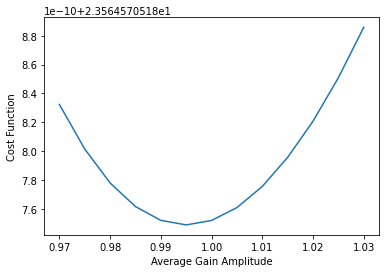

In [30]:
for stddev_ind in range(3):
    use_trial = 0
    gains = gain_vals[:, use_trial, 1]+1
    visibilities = vis_diff_vals[:, use_trial, 1] + data_sim_vis_no_noise
    mean_gain_amp = np.mean(np.abs(gains))
    use_gain_amps = np.arange(1.-.03, 1.+.03, .005)
    cost_function_result = np.zeros(np.shape(use_gain_amps))
    for ind, use_gain_amp in enumerate(use_gain_amps):
        scaled_gains = gains*use_gain_amp/mean_gain_amp
        scaled_visibilities = visibilities*(mean_gain_amp/use_gain_amp)**2.
        #print(mean_gain_amp)
        x_result = np.concatenate((
            np.real(scaled_gains), np.imag(scaled_gains),
            np.real(scaled_visibilities), np.imag(scaled_visibilities)
        ))

        cost_function_result[ind] = cost_function(
            x_result, 
            N_red_baselines, N_ants, baseline_cov_inv, model_sim_visibilities, a_mat,
            gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev_use, model_stddev_use_vals[stddev_ind]
        )
    print(cost_function_result)
    #cost_function_result_scaled = (cost_function_result-np.min(cost_function_result))/(np.max(cost_function_result)-np.min(cost_function_result))
    plt.plot(use_gain_amps, cost_function_result)
    #plt.plot([mean_gain_amp,mean_gain_amp], [0,1])
    plt.xlabel('Average Gain Amplitude')
    plt.ylabel('Cost Function')
    #plt.ylim([0,1])
    plt.show()

In [31]:
stddev_ind = 2
gains = gain_vals[:, 0, stddev_ind]+1
visibilities = vis_diff_vals[:, 0, stddev_ind] + data_sim_vis_no_noise
gains*=1.01
visibilities/=1.01**2

fitted_visibilities_expanded = np.matmul(a_mat, visibilities)
gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
print(prob/data_stddev_use**2)

vis_diff = visibilities-model_sim_visibilities
prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_inv), vis_diff))
print(prior/model_stddev_use_vals[stddev_ind]**2)

1.7862549272637343e-17
1.1976844780733216e-10


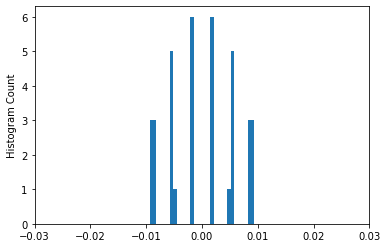

In [32]:
bins = np.linspace(-.03, .03, num=100)
plt.hist(np.imag(gain_vals[:, :, 2]).flatten(), bins=bins)
#plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-.03, .03)
plt.show()

[-0.00899682 -0.00891526 -0.00883369 -0.00875213 -0.00867057 -0.008589
 -0.00547971 -0.00539814 -0.00531658 -0.00523501 -0.00515344 -0.00507188
 -0.00196252 -0.00188096 -0.00179939 -0.00171782 -0.00163625 -0.00155469
  0.00155469  0.00163625  0.00171782  0.00179939  0.00188096  0.00196252
  0.00507188  0.00515344  0.00523501  0.00531658  0.00539814  0.00547971
  0.008589    0.00867057  0.00875213  0.00883369  0.00891526  0.00899682]


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


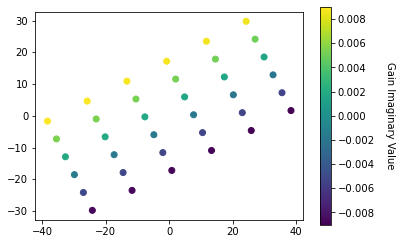

In [33]:
colors = np.imag(np.mean(gain_vals[:, :, 2], axis=1))
print(colors)
plt.scatter(data_sim_expanded.antenna_positions[:,0], data_sim_expanded.antenna_positions[:,1], c=colors)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Gain Imaginary Value', rotation=270, labelpad=20)
plt.axes().set_aspect('equal')